In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias, detrend_members, split_retrain
from exp_hp import get_hp
#from utils import detrend_members

2024-08-30 14:37:08.872112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 14:37:09.155742: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


### Load standardized E3SM

In [3]:
EXP_NAME = 'exp2'
hps = get_hp(EXP_NAME)
print('Training Members: '+str(hps['train_mems']))
print('Validation Member: '+str(hps['val_mems'][0]))
print('Testing Member: '+str(hps['test_mems'][0]))
print('Lead: '+str(hps['LEAD']))
print('Region: '+str(hps['region'][0])+'N x '+str(hps['region'][1])+'E')

_, _, X1test, _, _, Y1test, inew = split_SDbias(trainmems = hps['train_mems'],
                                                  valmem = hps['val_mems'][0],
                                                  testmem = hps['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps['LEAD'])

X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))

GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

Training Members: ['0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181']
Validation Member: 0191
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
files do not exist - loading data & saving


### Test NN

0


2024-08-30 14:37:53.626457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


235/235 [==============================] - 0s 808us/step
1
235/235 [==============================] - 0s 2ms/step
2
235/235 [==============================] - 0s 2ms/step
3
235/235 [==============================] - 0s 1ms/step
4
235/235 [==============================] - 0s 1ms/step
5
235/235 [==============================] - 0s 789us/step
6
235/235 [==============================] - 1s 2ms/step
7
235/235 [==============================] - 0s 2ms/step
8
235/235 [==============================] - 0s 1ms/step
9
235/235 [==============================] - 0s 1ms/step


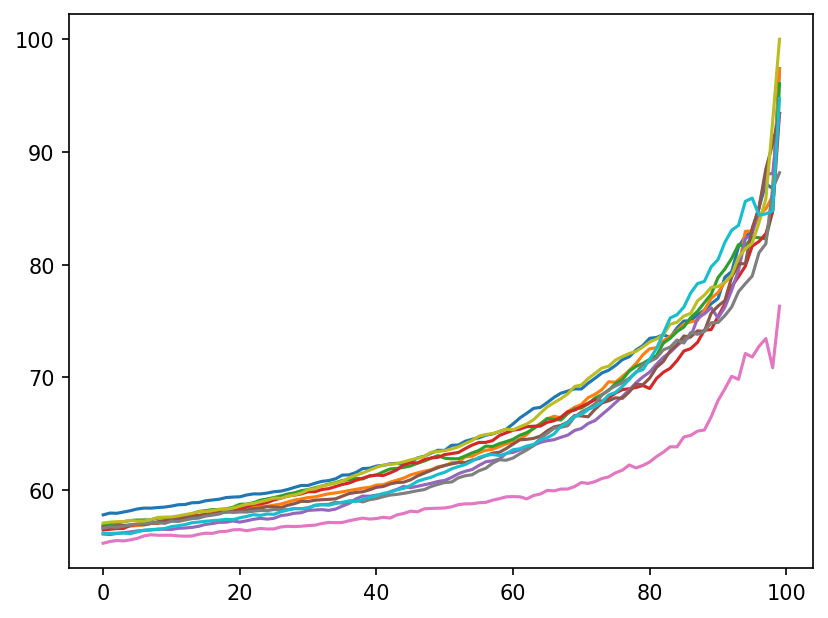

In [4]:
#----- SET UP & TRAIN NN -----
acc_all = []
for SEED in range(10):
    print(SEED)
    annfi_name = 'ann_60Eshift_check_seed'+str(SEED)+'.h5'
    ann = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)
    
    pred = ann.predict(X1test)
    acc = []
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)

    for q in range(100):
        iconf = np.where(predconf >= np.percentile(predconf,q=q))
        icorr = np.where(predval[iconf] == Y1test[iconf])
        
        acc.append((len(icorr[0])/len(iconf[0]))*100)
    plt.plot(acc)
    
    acc_all.append(acc)

# np.save(base_dir+'test/confvsacc/confvsacc_ann1_60Eshift_check.npy', acc_all, allow_pickle=True)